In [1]:
!unzip '/content/hw3.zip'

Archive:  /content/hw3.zip
  inflating: HW3.tex                 
  inflating: __MACOSX/._HW3.tex      
   creating: datasets/
  inflating: __MACOSX/._datasets     
  inflating: datasets/hw3_cancer.csv  
  inflating: __MACOSX/datasets/._hw3_cancer.csv  
  inflating: datasets/hw3_house_votes_84.csv  
  inflating: __MACOSX/datasets/._hw3_house_votes_84.csv  
  inflating: datasets/hw3_wine.csv   
  inflating: __MACOSX/datasets/._hw3_wine.csv  
   creating: figures/
  inflating: figures/cross_val_stratified2.png  
  inflating: __MACOSX/figures/._cross_val_stratified2.png  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

In [3]:
class DT:
    def __init__(self, max_depth=10, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def entropy(self, labels):
        label, counts = np.unique(labels, return_counts=True)
        prob = counts / counts.sum()
        return -np.sum(prob * np.log2(prob))

    def information_gain_numerical(self, labels, true_labels, false_labels):
        prob = float(len(true_labels)) / len(labels)
        info_gain = self.entropy(labels) - prob * self.entropy(true_labels) - (1 - prob) * self.entropy(false_labels)
        return info_gain

    def information_gain_categorical(self, labels, partitions):
        values, counts = np.unique(partitions, return_counts=True)
        avg_entropy_of_partitions = sum((counts[i] / sum(counts)) * self.entropy(labels[partitions == value]) for i, value in enumerate(values))
        return self.entropy(labels) - avg_entropy_of_partitions

    def best_split(self, features, labels, feature_types, min_info_gain=0.01):
        best_gain = -np.inf
        best_feature = None
        best_split_val = None
        m = int(math.sqrt(len(features.columns)))
        m_features = np.random.choice(features.columns, m, replace=False)
        for feature in m_features:
            if feature_types[feature] == "categorical":
                info_gain = self.information_gain_categorical(labels, features[feature])
                if info_gain > best_gain and info_gain >= min_info_gain:
                    best_gain, best_feature = info_gain, feature
                    best_split_val = None
            else:
                sorted_indices = features[feature].sort_values().index
                sorted_labels = labels.loc[sorted_indices]
                sorted_features = features.loc[sorted_indices, feature]
                for i in range(1, len(sorted_features)):
                    if sorted_features.iloc[i] == sorted_features.iloc[i - 1]:
                        continue
                    split_val = (sorted_features.iloc[i] + sorted_features.iloc[i - 1]) / 2
                    true_labels = sorted_labels[sorted_features <= split_val]
                    false_labels = sorted_labels[sorted_features > split_val]
                    info_gain = self.information_gain_numerical(labels, true_labels, false_labels)
                    if info_gain > best_gain and info_gain >= min_info_gain:
                        best_gain, best_feature, best_split_val = info_gain, feature, split_val
        return best_feature, best_split_val

    def build_dt(self, features, labels, feature_types, depth=0):
        if len(np.unique(labels)) == 1 or len(features) < self.min_samples_leaf or (self.max_depth and depth >= self.max_depth):
            return np.unique(labels)[0]
        else:
            best_feature, best_split_val = self.best_split(features, labels, feature_types)
            if best_feature is None:
                return np.unique(labels)[np.argmax(np.unique(labels, return_counts=True)[1])]
            tree = {best_feature: {}}
            if best_split_val is None:
                for value in np.unique(features[best_feature]):
                    subtree_features = features[features[best_feature] == value].drop(columns=[best_feature])
                    subtree_labels = labels[features[best_feature] == value]
                    subtree = self.build_dt(subtree_features, subtree_labels, feature_types, depth + 1)
                    tree[best_feature][value] = subtree
            else:
                left_indices = features[best_feature] <= best_split_val
                right_indices = features[best_feature] > best_split_val
                left_subtree = self.build_dt(features[left_indices], labels[left_indices], feature_types, depth + 1)
                right_subtree = self.build_dt(features[right_indices], labels[right_indices], feature_types, depth + 1)
                tree[best_feature] = {"<= {:.2f}".format(best_split_val): left_subtree , "> {:.2f}".format(best_split_val): right_subtree}
            return tree

    def fit(self, features, labels, feature_types):
        self.feature_types = feature_types
        self.tree = self.build_dt(features, labels, feature_types)

    def predict(self, dataset):
        predictions = []
        for _, instance in dataset.iterrows():
            prediction = self.predict_helper(instance, self.tree)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_helper(self, instance, tree):
        if not isinstance(tree, dict):
            return tree
        feature = next(iter(tree))
        if self.feature_types[feature] == 'categorical':
            if instance[feature] in tree[feature]:
                return self.predict_helper(instance, tree[feature][instance[feature]])
        else:
            for key, subtree in tree[feature].items():
                if key.startswith('<='):
                    split_val = float(key.split('<= ')[1])
                    if instance[feature] <= split_val:
                        return self.predict_helper(instance, subtree)
                elif key.startswith('>'):
                    split_val = float(key.split('> ')[1])
                    if instance[feature] > split_val:
                        return self.predict_helper(instance, subtree)
                else:
                    if instance[feature] == key:
                        return self.predict_helper(instance, subtree)
        return np.nan


In [4]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_leaf=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def bootstrap(self, features, labels):
        num_samples = features.shape[0]
        indices = np.random.choice(num_samples, num_samples, replace=True)
        return features.iloc[indices], labels.iloc[indices]

    def fit(self, features, labels, feature_types):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DT(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            features_sample, labels_sample = self.bootstrap(features, labels)
            tree.fit(features_sample, labels_sample, feature_types)
            self.trees.append(tree)

    def predict(self, instances):
        tree_preds = [tree.predict(instances) for tree in self.trees]
        tree_preds = np.array(tree_preds).T
        majority_votes = [self.most_common_label(pred) for pred in tree_preds]
        return np.array(majority_votes)

    def most_common_label(self, pred):
        return Counter(pred).most_common(1)[0][0]

In [5]:
def stratified_cross_validation(features, labels, k=10):
    y = labels.to_numpy()
    label_indices = [np.where(y == label)[0] for label in np.unique(y)]
    folds = []
    pairs = []
    shuffled_label_indices = [np.random.permutation(label_list) for label_list in label_indices]
    label_splits = [np.array_split(label_list, k) for label_list in shuffled_label_indices]
    for fold_parts in zip(*label_splits):
        fold = np.concatenate(fold_parts)
        folds.append(fold)
    for fold_index in range(k):
        test_fold = folds[fold_index]
        train_fold = np.concatenate([folds[i] for i in range(k) if i != fold_index])
        pairs.append((train_fold, test_fold))
    return pairs

In [6]:
def unique_labels_filter(true_labels):
    filtered_labels = [label for label in true_labels if not np.isnan(label)]
    return np.unique(filtered_labels)

def mc_cm(true_labels, predictions, num_classes):
    unique_labels = unique_labels_filter(true_labels)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    confusion_matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]
    for true, pred in zip(true_labels, predictions):
        if np.isnan(pred):
            continue
        true_idx = label_to_index[true]
        pred_idx = label_to_index.get(pred, -1)
        if pred_idx != -1:
            confusion_matrix[true_idx][pred_idx] += 1
    return confusion_matrix

def metrics_calc(confusion_matrix):
    metrics = {'precision': [], 'recall': [], 'f1': []}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i][i]
        FN = sum(confusion_matrix[i][j] for j in range(len(confusion_matrix)) if j != i)
        FP = sum(confusion_matrix[j][i] for j in range(len(confusion_matrix)) if j != i)
        TN = sum(sum(confusion_matrix[j][k] for k in range(len(confusion_matrix)) if k != i) for j in range(len(confusion_matrix)) if j != i)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        metrics['f1'].append(f1)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
    for metric in metrics:
        metrics[metric] = sum(metrics[metric]) / len(metrics[metric])
    return metrics


In [7]:
def evaluate_rf(features, labels, feature_types, k=10, ntree=1):
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    pairs = stratified_cross_validation(features, labels, k=k)
    num_classes = len(np.unique(labels))
    for train_indices, test_indices in pairs:
        features_train, labels_train = features.iloc[train_indices], labels.iloc[train_indices]
        features_test, labels_test = features.iloc[test_indices], labels.iloc[test_indices]
        ensemble = RandomForest(n_trees=ntree, max_depth=10, min_samples_leaf=1)
        ensemble.fit(features_train, labels_train, feature_types)
        predictions = ensemble.predict(features_test)
        confusion_matrix = mc_cm(labels_test.to_numpy(), predictions, num_classes)
        metrics = metrics_calc(confusion_matrix)
        accuracy = sum(confusion_matrix[i][i] for i in range(num_classes)) / sum(sum(row) for row in confusion_matrix)
        scores['accuracy'].append(accuracy)
        scores['precision'].append(metrics['precision'])
        scores['recall'].append(metrics['recall'])
        scores['f1'].append(metrics['f1'])
    avg_perf = {metric: np.mean(values) for metric, values in scores.items()}
    return avg_perf


#Analyzing the Breast Cancer Dataset

In [8]:
cancer_dataset = pd.read_csv('datasets/hw3_cancer.csv', delimiter='\t')
cancer_dataset.head()

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5.0,1.0,1.0,1.0,2.0,0,3.0,1.0,1.0,0
1,5.0,4.0,4.0,5.0,7.0,1,3.0,2.0,1.0,0
2,3.0,1.0,1.0,1.0,2.0,2,3.0,1.0,1.0,0
3,6.0,8.0,8.0,1.0,3.0,4,3.0,7.0,1.0,0
4,4.0,1.0,1.0,3.0,2.0,0,3.0,1.0,1.0,0


In [9]:
cancer_dataset.groupby('Class').size()

Class
0    458
1    241
dtype: int64

In [10]:
num_instances = len(cancer_dataset)
num_instances

699

In [11]:
cancer_features = cancer_dataset.drop('Class', axis=1)
cancer_labels = cancer_dataset['Class']
cancer_feature_types = {}
for column in cancer_dataset.columns:
    if column == 'Class':
        continue
    cancer_feature_types[column] = 'numerical'
cancer_feature_types

{'Clump_Thickness': 'numerical',
 'Cell_Size_Uniformity': 'numerical',
 'Cell_Shape_Uniformity': 'numerical',
 'Marginal_Adhesion': 'numerical',
 'Single_Epi_Cell_Size': 'numerical',
 'Bare_Nuclei': 'numerical',
 'Bland_Chromatin': 'numerical',
 'Normal_Nucleoli': 'numerical',
 'Mitoses': 'numerical'}

In [12]:
average_performance_1 = evaluate_rf(cancer_features, cancer_labels, cancer_feature_types, k=10, ntree=1)
print(f"Metrics for a value of ntree = {1}: {average_performance_1}")


Metrics for a value of ntree = 1: {'accuracy': 0.8657705654215146, 'precision': 0.8783686856815557, 'recall': 0.8274625603864733, 'f1': 0.8269240721910436}


In [ ]:
ntree_values = [1, 5, 10, 20, 30, 40, 50]
metrics_results = {'ntree': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for ntree in ntree_values:
    average_performance = evaluate_rf(cancer_features, cancer_labels, cancer_feature_types, k=10, ntree=ntree)
    metrics_results['ntree'].append(ntree)
    metrics_results['accuracy'].append(average_performance['accuracy'])
    metrics_results['precision'].append(average_performance['precision'])
    metrics_results['recall'].append(average_performance['recall'])
    metrics_results['f1'].append(average_performance['f1'])
    print(f"Metrics for a value of ntree = {ntree}: {average_performance}")

Metrics for a value of ntree = 1: {'accuracy': 0.8898285364360075, 'precision': 0.9025219990329665, 'recall': 0.854150966183575, 'f1': 0.8659407308463625}
Metrics for a value of ntree = 5: {'accuracy': 0.9369553553203278, 'precision': 0.93818803068316, 'recall': 0.926123188405797, 'f1': 0.9293509489668696}
Metrics for a value of ntree = 10: {'accuracy': 0.9599580089231038, 'precision': 0.9532972222042527, 'recall': 0.9615458937198067, 'f1': 0.956386617354239}
Metrics for a value of ntree = 20: {'accuracy': 0.9614469425247135, 'precision': 0.9555087738531686, 'recall': 0.9607234299516907, 'f1': 0.9577096095937254}
Metrics for a value of ntree = 30: {'accuracy': 0.9642017321319221, 'precision': 0.9582481344160346, 'recall': 0.9647826086956522, 'f1': 0.9608167711095875}
Metrics for a value of ntree = 40: {'accuracy': 0.9656521739130437, 'precision': 0.958827152357887, 'recall': 0.9688828502415457, 'f1': 0.9627539303682144}
Metrics for a value of ntree = 50: {'accuracy': 0.9641816114075759

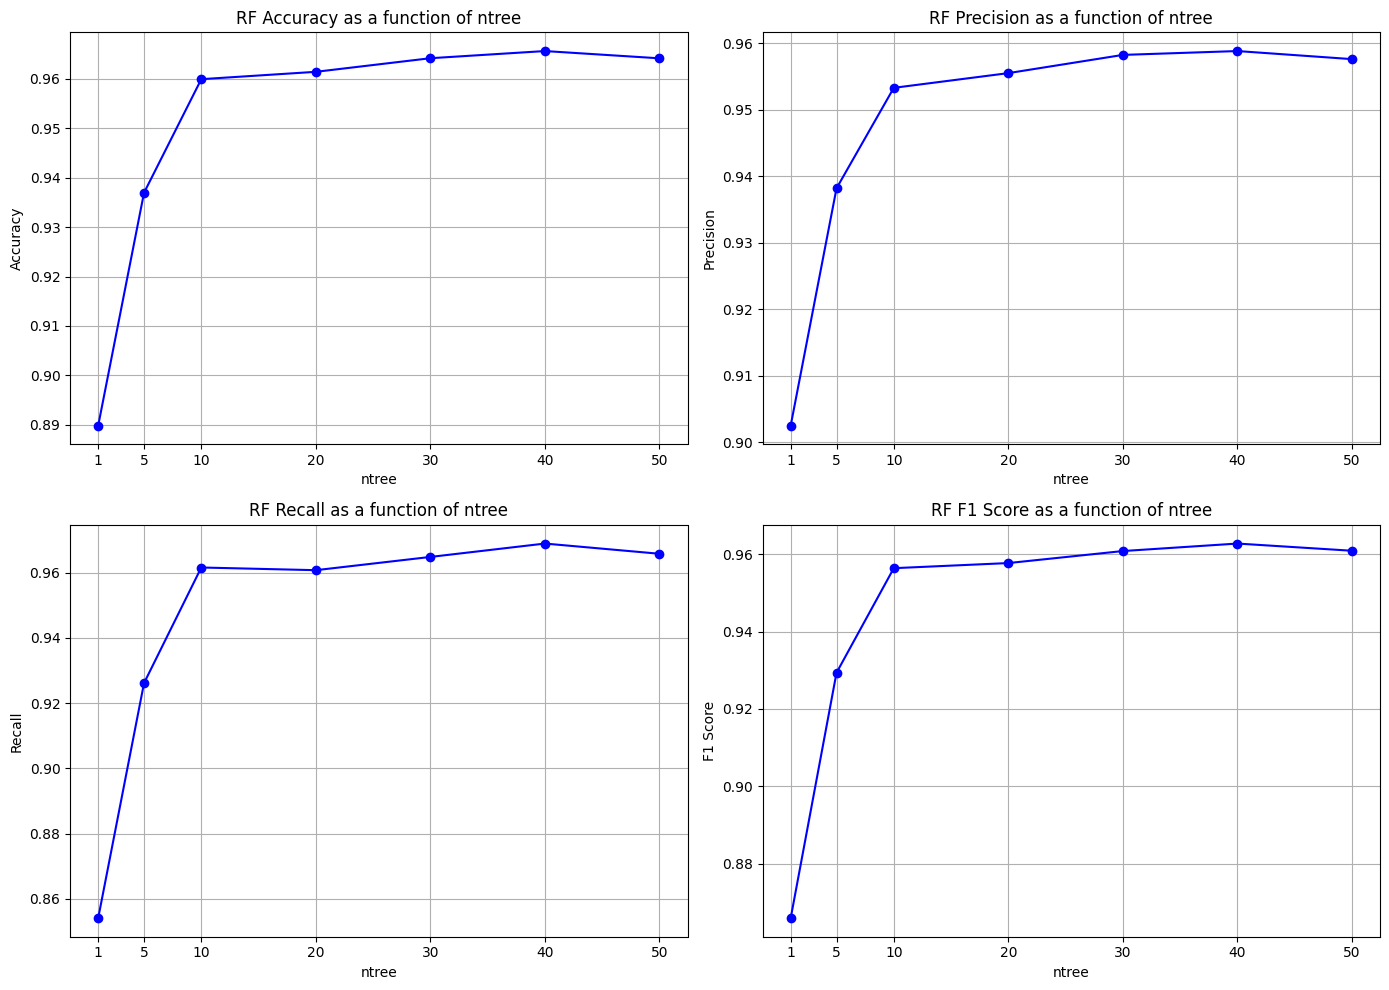

In [ ]:
def plot(metrics):
    plt.figure(figsize=(14, 10))
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1'], start=1):
        plt.subplot(2, 2, i)
        plt.plot(metrics['ntree'], metrics[metric], marker='o', linestyle='-', color='b')
        plt.title(f'RF {titles[i-1]} as a function of ntree')
        plt.xlabel('ntree')
        plt.ylabel(titles[i-1])
        plt.xticks(metrics_results['ntree'])
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot(metrics_results)

*4.* For each metric being evaluated (and for each dataset), discuss which value of ntree you would
select if you were to deploy this classifier in real life. Explain your reasoning.


In the context of the Breast Cancer Dataset, the primary goal is accurately classifying biopsy samples to detect cancer, the choice of ntree (the number of trees in the random forest) is very important since we're dealing with a life or death situation if we end up misdiagnozing. Each of the metrics: accuracy, precision, recall, and F1 score play an important role in evaluating the model's performance. We're going to select the value of ntree keeping in mind both performance and computational efficiency. Also recall is the most important metric in a medical diagnosis so having a high recall is one of our aims.

Accuracy reaches its peak witg ntree = 40 (0.9656). This value indicates the model's ability to correctly classify both classes. While accuracy is important, we can't base our entire decision on accuracy alone, especially in medical diagnostics where the cost of FP is particularly high.

Precision peaks at various points, ntree = 40 also shows the highest precision (0.9588) however it's really negligeable compared to ntree = 30 and ntree = 50. Precision indicates the model's ability to minimize FP, in other words classifying non cancerous tissue as cancerous. In a medical context, while high precision is desirable to avoid unnecessary anxiety or treatment, it's recall that's more important so we don't end up missing a cancerous tissue which might lead to a patient's probability of recovery going down.

Recall reaches its highest ntree = 40, with a recall of 0.9688. Recall is the most critical metric in this scenario since it measures the model's ability to identify all actual positive cases (all cancerous tissues). A high recall reduces the risk of falsely classifying cancerous tissues as benign, which could delay treatment. Given the serious implications of missed cancer diagnoses, a slightly higher computational cost for increased recall ntree = 40 is a worth it trade-off.

F1 Score also reaches it's maximum at ntree = 40, with an F1 score of 0.9627. The F1 score provides a balance between precision and recall, making it a robust metric for model evaluation. The high F1 score at ntree = 40 suggests an effective balance, crucial for medical applications where both FP and FN carry significant consequences.

In the context of breast cancer diagnosis, we don't want to overwhelme people with FP. The trade-off between precision and recall are very important here this is why our model must carefully consider these metrics to ensure an optimal balance selecting an ntree value that maximizes performance while considering computational efficiency and the clinical implications of FN and FP.

So ntree = 40 is the best choice across all metrics, offering an excellent balance between accuracy, precision, recall, and F1 score. This might come at the expense of increased computational resources and longer training times, however it's worth it considering that in medical diagnosis the emphasis must be on performance particularly recall so no treatment gets delayed or ignored.

*5.* Discuss (on a high level) which metrics were more directly affected by changing the value of
ntree and, more generally, how such changes affected the performance of your algorithm. For
instance: was the accuracy of the random forest particularly sensitive to increasing ntree past a
given value? Was the F1 score a “harder” metric to optimize, possibly requiring a significant
number of trees in the ensemble? Is there a point beyond which adding more trees does not
improve performance—or makes the performance worse?


The model's accuracy improves consistently with the increase in ntree, peaking at ntree = 40 so adding more trees enhanced its overall classification ability. However, after a certain threshhold (here 40) performance started decreasing.

At ntree = 20 while precision shows an increase, recall does not show any improvement (a smal drop in performance). This discrepancy highlights a critical trade-off between minimizing FP and ensuring high recall. The boost in precision at ntree = 20 suggests that the ensemble becomes better at ensuring its positive predictions are correct but without a significant increase in recall.

At ntree = 20 where recall doesn't improve alongside precision shows the challenge in optimizing the F1 score. We need a balance between the two metrics so we need to take all steps necessary to ensure both metrics are benefitting in the same way and not one benefetting on the expense of the other.

We see that beyond a certain point adding more trees has a negative impact on model performance. Also for ntree = 20 we saw that adding more trees doesn't necessarily impacts all metrics in the same way with precision improving and recall staying somewhat the same, we need to keep an eye on this while using random forests.
At ntree = 50, all metrics slightly decrease possibly due to overfitting or because the model's becoming too complex. This is not good since generalization becomes bad and our model is hence not efficient.
